In [1]:
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx

## Set Font to Match Website

In [2]:
from matplotlib import font_manager

font_path = '/usr/share/fonts/truetype/lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

## Load Data and Prep Columns

In [3]:
ejblocks = gpd.read_file("../data/joins/ejblocks.shp.zip")

In [4]:
cols = ["AC_5","AC_10","AC_15","AC_20","AC_30","AC_45","AC_60"]
cols_bools = [col+"_bool" for col in cols]
cols_pops = [col+"_pop" for col in cols]
ejblocks["TC_bool"] = ejblocks["TC"] > 0
for i in range(len(cols)):
    if i == 0:
        ejblocks[cols_bools[i]] = ejblocks[cols[i]] > 0
    else:
        ejblocks[cols_bools[i]] = (ejblocks[cols[i]] > 0) | ejblocks[cols_bools[i-1]]
    ejblocks[cols_pops[i]] = np.where(ejblocks[cols_bools[i]], ejblocks["P1_001N"], 0)

## Plot Boolean Analyses

In [5]:
def plot_by_group(groupby_col = "TC_bool", r=False, dpi=100):
    # reverse the colors of the boolean variable if requested
    if r:
        palette = {False:"crimson", True:"green"}
    else:
        palette = {True:"crimson", False:"green"}

    # group by the requested variable and calculate percents (as well as standard deviation)
    g = ejblocks.groupby([groupby_col])[["P1_001N", *cols_pops]]
    p = g.sum()[cols_pops].divide(g.sum()["P1_001N"], axis='index')
    percents = (p * 100).melt(ignore_index=False, value_name="mean").reset_index()
    percents_std= np.sqrt(p*(1-p)*100).melt(ignore_index=False, value_name="std").reset_index()
    percents = pd.concat([percents, percents_std["std"]], axis=1)

    # initial plot
    fig, ax = plt.subplots(dpi=dpi)
    ax = sns.barplot(
        percents,
        x="variable",
        y="mean",
        hue=groupby_col,
        errorbar=None,
        palette=palette,
        ax=ax
    )
    ax.set_ylim(0,100)
    ax.set_title("Percent of Population with Conserved Land within Walk Times")
    ax.set_ylabel("% of Population")
    ax.set_xlabel("Conservation Land within $x$-Minute Walk")
    ax.legend(title="\"Disadvantaged\"")

    # manual error bars
    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
    y_coords = [p.get_height() for p in ax.patches]
    ax.errorbar(x=x_coords, y=y_coords, yerr=percents["std"].values, fmt="none", c="k")
    
    # use just the numeric component of the x variables
    ax.set_xticklabels([label.get_text().split("_")[1] for label in ax.get_xticklabels()])

    # adjust widths to reflect proportion of overall population
    widths = 0.5 * np.tile(np.sqrt(g.sum()["P1_001N"] / g.sum()["P1_001N"].sum()).to_numpy().reshape(-1,1), p.shape[1])
    for bar, newwidth in zip(ax.patches, widths.ravel()):
        x = bar.get_x()
        width = bar.get_width()
        center = x + width/2.
        bar.set_x(center - newwidth/2.)
        bar.set_width(newwidth)
    
    return fig, ax

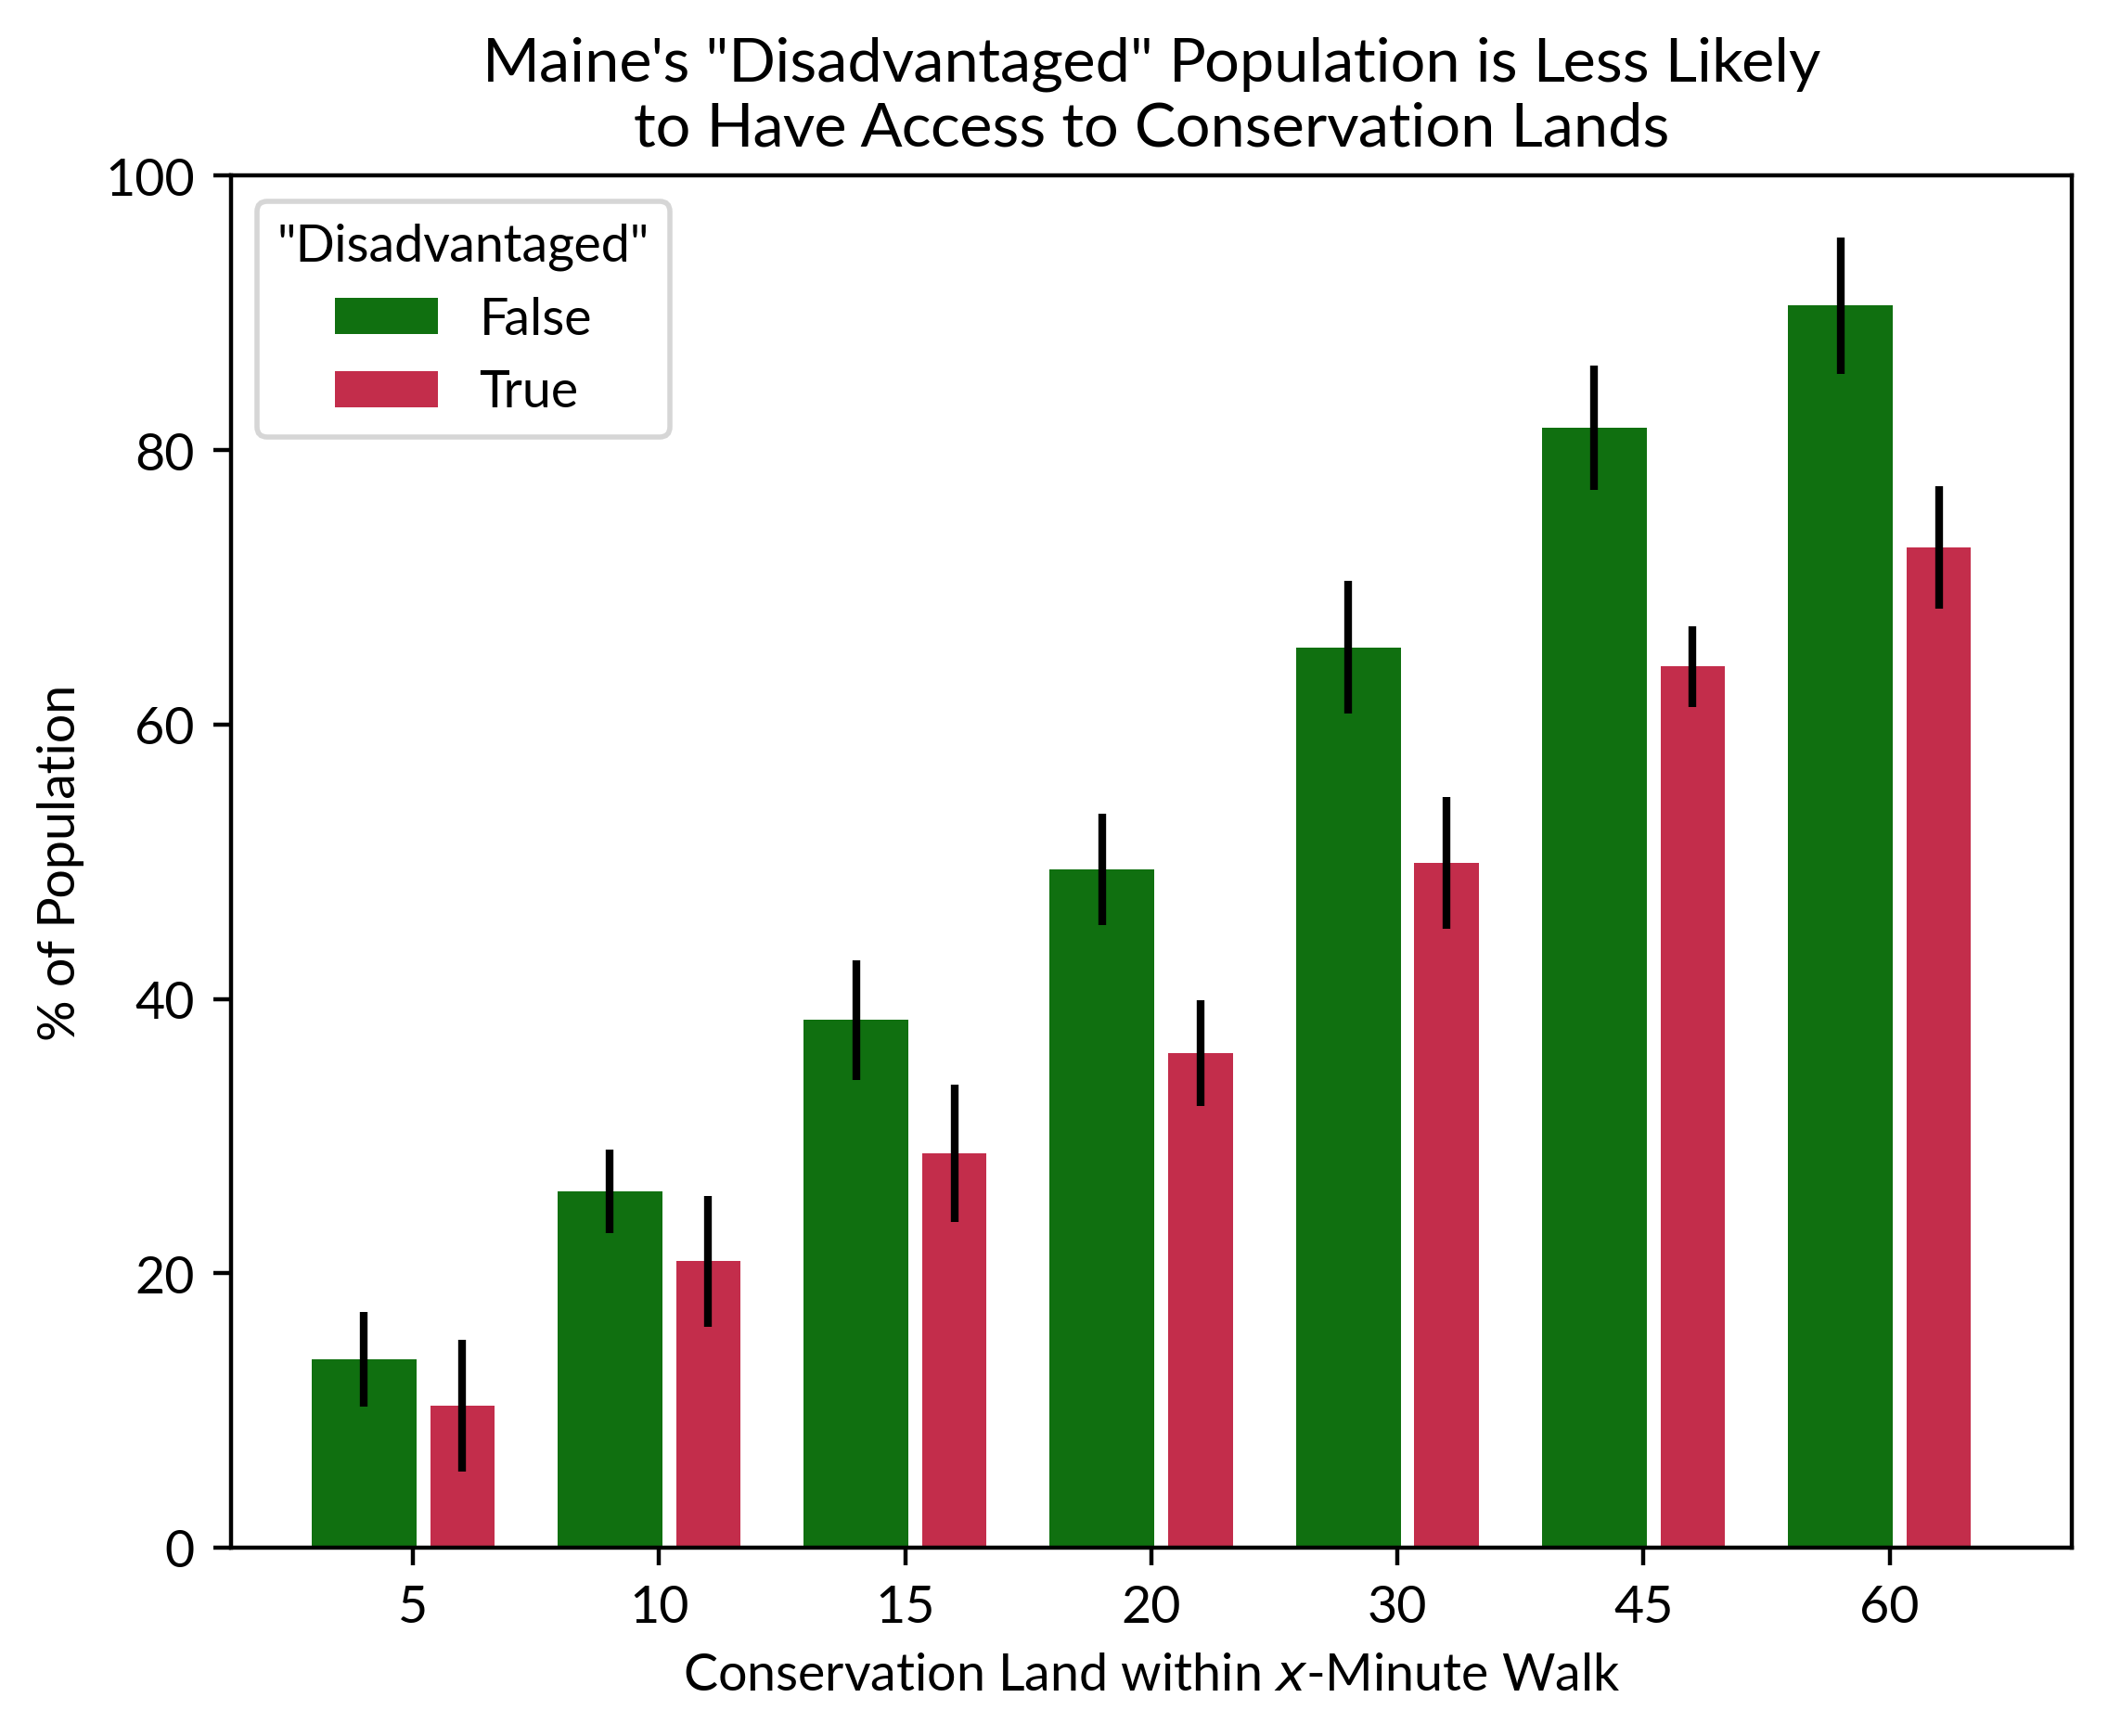

In [6]:
fig, ax = plot_by_group("TC_bool", dpi=400)
ax.legend(title="\"Disadvantaged\"", loc='best')
ax.set_title("Maine's \"Disadvantaged\" Population is Less Likely\nto Have Access to Conservation Lands", {'fontname':'Lato'})
fig.savefig("../figs/disadvantaged_barplot.png")

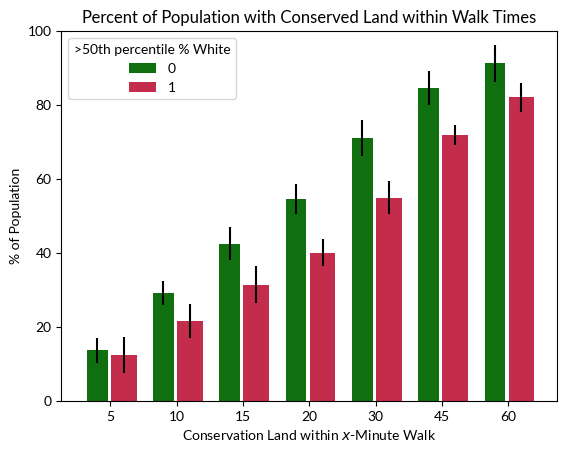

In [7]:
fig, ax = plot_by_group("white_50", r=False)
ax.legend(title=">50th percentile % White", loc='best')

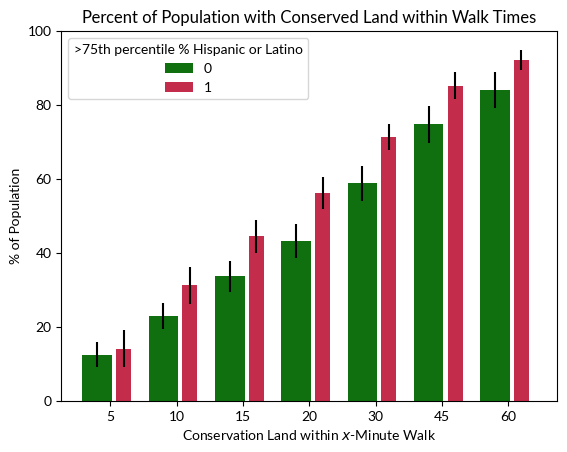

In [8]:
fig, ax = plot_by_group("hisp_75", False)
ax.legend(title=">75th percentile % Hispanic or Latino", loc='best')

## Closest Conserved Lands

In [11]:
melt = ejblocks[ejblocks["ALAND20"] > 0].melt(id_vars=["GEOID20","geometry", "TC_bool"],value_vars=cols_bools)
melt["nearest"] = np.where(melt["value"], melt["variable"].apply(lambda s: int(s.split("_")[1])), 60)
melt = gpd.GeoDataFrame(melt.groupby("GEOID20").agg({
    "geometry":"first",
    "nearest":"min",
    "TC_bool":"max"
})).set_crs("EPSG:3857")

<AxesSubplot: >

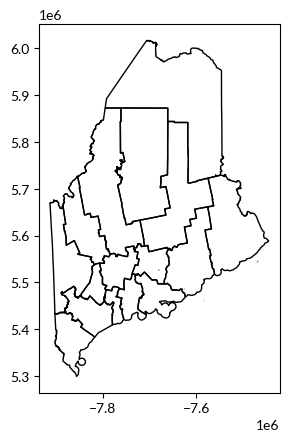

In [21]:
counties = gpd.read_file("https://services1.arcgis.com/RbMX0mRVOFNTdLzd/arcgis/rest/services/Maine_County_Boundary_Polygons_Dissolved/FeatureServer/0/query?outFields=*&where=1%3D1&outSR=3857&f=geojson")
counties.plot(facecolor='none', edgecolor="k")

Text(0.5, 1.0, 'Walk Time to Nearest Conserved Land')

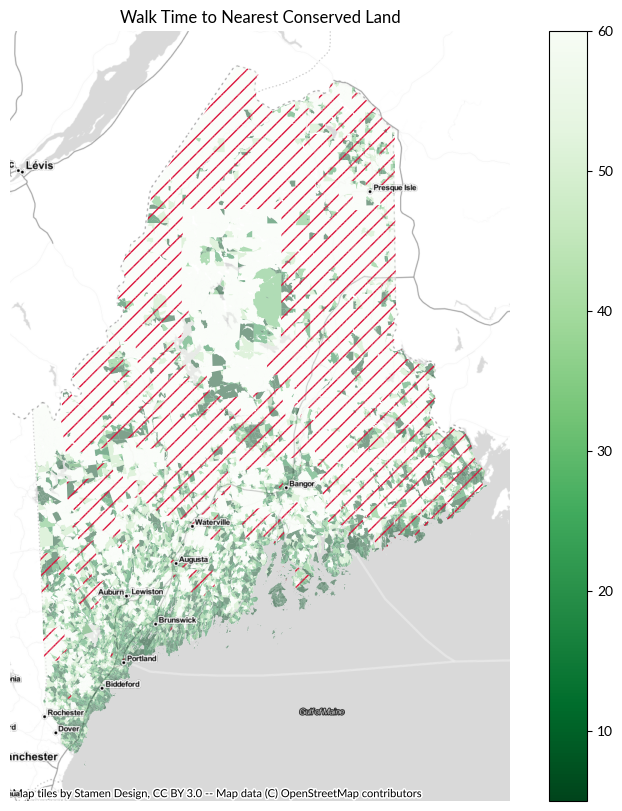

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
melt.plot("nearest", ax=ax, cmap="Greens_r", legend=True, alpha=0.5, aspect='equal')
melt[melt["TC_bool"]].plot(ax=ax, facecolor='none', edgecolor="crimson", hatch="//", linewidth=0)
ax.axis("off")
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.set_title("Walk Time to Nearest Conserved Land")

In [23]:
fig, ax = plt.subplots(figsize=(36,36), dpi=300)
melt.plot("nearest", ax=ax, cmap="Greens_r", legend=False, alpha=0.5, edgecolor='none')
melt[melt["TC_bool"]].plot(ax=ax, facecolor='none', edgecolor="crimson", hatch="//", linewidth=0)
ax.set_position([0, 0, 1, 1])
ax.axis("off")
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite, zoom=10)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels, zoom=10)
fig.savefig("../figs/minimum_walk_time.jpg")
fig.clf() # clear figure so that it is not saved within the notebook .ipynb file

<Figure size 10800x10800 with 0 Axes>

In [13]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)
melt.plot("nearest", ax=ax, cmap="Greens_r", legend=False, edgecolor=None)
counties.plot(ax=ax, facecolor="none", edgecolor='k', lw=0.125)
ax.axis("off")
ax.set_position([0,0,1,1])

cmap = mpl.cm.get_cmap("Greens_r")
bounds = [0,5,10,15,20,30,45,60]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')
fig.savefig("../figs/minimum_walk_time.png")
fig.clf() # clear figure so that it is not saved within the notebook .ipynb file

fig, ax = plt.subplots(figsize=(4,0.5), dpi=300)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal',
             label="Walk Time (min)")
fig.savefig("../figs/minimum_walk_time_legend.svg")
fig.clf() # clear figure so that it is not saved within the notebook .ipynb file

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x150 with 0 Axes>